In [1]:
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from BorutaShap import BorutaShap
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.inspection import PartialDependenceDisplay


C:\Users\yadum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


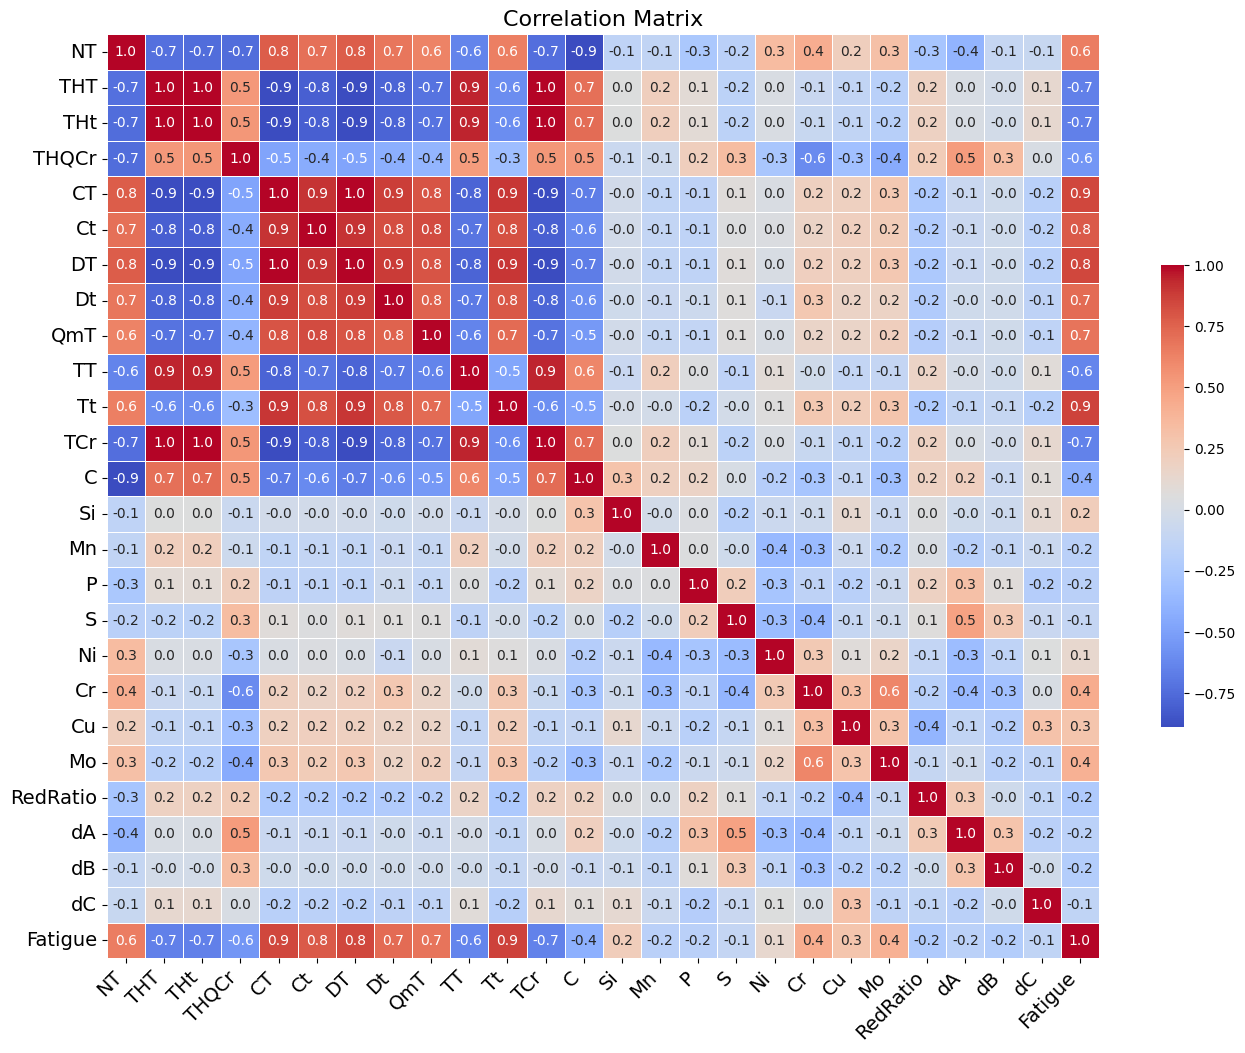

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')
df.drop('Sl. No.', axis=1, inplace=True)
corr = df.corr()

f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".1f", 
            linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict


X = df.drop('Fatigue', axis = 1)
y = df.Fatigue

index_carburizing = -48  # The last 48 entries are carburizing steels
index_spring = -48-18    # The previous 18  are spring steels

X_carburizing = X.iloc[index_carburizing:]
y_carburizing = y.iloc[index_carburizing:]
X_spring = X.iloc[index_spring:index_carburizing]
y_spring = y.iloc[index_spring:index_carburizing]
X_carbon_low_alloy = X.iloc[:index_spring]
# print(X_carbon_low_alloy)
y_carbon_low_alloy = y.iloc[:index_spring]

X_train_carburizing, X_test_carburizing, y_train_carburizing, y_test_carburizing = train_test_split(
    X_carburizing, y_carburizing, test_size=0.2, random_state=44)

X_train_spring, X_test_spring, y_train_spring, y_test_spring = train_test_split(
    X_spring, y_spring, test_size=0.2, random_state=44)

X_train_carbon_low_alloy, X_test_carbon_low_alloy, y_train_carbon_low_alloy, y_test_carbon_low_alloy = train_test_split(
    X_carbon_low_alloy, y_carbon_low_alloy, test_size=0.2, random_state=44)

# Combine
X_train = pd.concat([X_train_carburizing, X_train_spring, X_train_carbon_low_alloy], ignore_index=False)
X_test = pd.concat([X_test_carburizing, X_test_spring, X_test_carbon_low_alloy], ignore_index=False)
y_train = pd.concat([y_train_carburizing, y_train_spring, y_train_carbon_low_alloy], ignore_index=False)
y_test = pd.concat([y_test_carburizing, y_test_spring, y_test_carbon_low_alloy], ignore_index=False)
# print(y_test)

model = SVR(kernel='linear')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



In [4]:
# BorutaShap does not work with SVM

# Feature_Selector = BorutaShap(model=model, importance_measure='shap', classification=False)
# Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=True, normalize=True, verbose=True)
# selected_features_BS = Feature_Selector.Subset()

In [4]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(
    estimator=model,
    min_features_to_select=5,
    step=1,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

rfecv.fit(X_train_scaled, y_train)
print(X_train.columns[rfecv.support_])
selected_features_RFE = X_train.columns[rfecv.support_]
print(len(X_train.columns[rfecv.support_]))

Index(['THQCr', 'CT', 'Ct', 'DT', 'QmT', 'TT', 'Tt', 'C', 'Si', 'Ni', 'Cr',
       'Mo'],
      dtype='object')
12


In [12]:
model = LinearRegression()
scalar = RobustScaler()
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
cv = LeaveOneOut()

# predictions_BS = cross_val_predict(pipeline, X_train[selected_features_BS.columns], y_train, cv=cv)
# r2_BS = r2_score(y_train, predictions_BS)
# print('R^2 value:, r2_BS)

predictions_RFE = cross_val_predict(pipeline, X_train[selected_features_RFE], y_train, cv=cv)
r2_RFE = r2_score(y_train, predictions_RFE)
print('R^2 RFE:', r2_RFE)

predictions_study = cross_val_predict(pipeline, X_train, y_train, cv=cv)
r2_study = r2_score(y_train, predictions_study)
print('R^2 Agrwal et al. Study:',r2_study)

R^2 RFE: 0.9622513461978113
R^2 Agrwal et al. Study: 0.964212062773998


In [13]:
pipeline.fit(X_train[selected_features_RFE], y_train)
predictions_RFE = pipeline.predict(X_test[selected_features_RFE])
r2_test_RFE = r2_score(y_test, predictions_RFE)
MSE_test_RFE = mean_squared_error(y_test, predictions_RFE)

print('Test R^2 with reduced feature set:', r2_test_RFE)
print('Test MSE with reduced feature set:', MSE_test_RFE)

ranges = {
    'Carbon and Low Alloy Steels': (0, 370),
    'Spring Steels': (371, 388),
    'Carburizing Steels': (389, 436)
}

for label, (start_idx, end_idx) in ranges.items():
    mask = y_test.index.isin(range(start_idx, end_idx+1))
    predictions_subset = predictions_RFE[mask]
    actual_subset = y_test[mask]
    r2_subset = mean_squared_error(actual_subset, predictions_subset)
    print(f'MSE for {label}: {r2_subset}')

Test R^2 with reduced feature set: 0.956801574642872
Test MSE with reduced feature set: 1709.5460141160884
MSE for Carbon and Low Alloy Steels: 594.1621643586233
MSE for Spring Steels: 7709.828358689894
MSE for Carburizing Steels: 7674.811949467554


In [14]:
mae_f = np.mean(np.abs((y_test - predictions_RFE) / (y_test)))
print('MAE_f:',mae_f)
rmse_f = np.sqrt(np.mean(((y_test - predictions_RFE) / (y_test))**2))
print('RMSE_f:',rmse_f)

rel_e = (y_test - predictions_RFE) / (y_test) - mae_f
sde_f = np.sqrt(np.mean(rel_e**2))
print('SDE_f:',sde_f)


MAE_f: 0.045956808254899874
RMSE_f: 0.06044398658261741
SDE_f: 0.07645121741877826


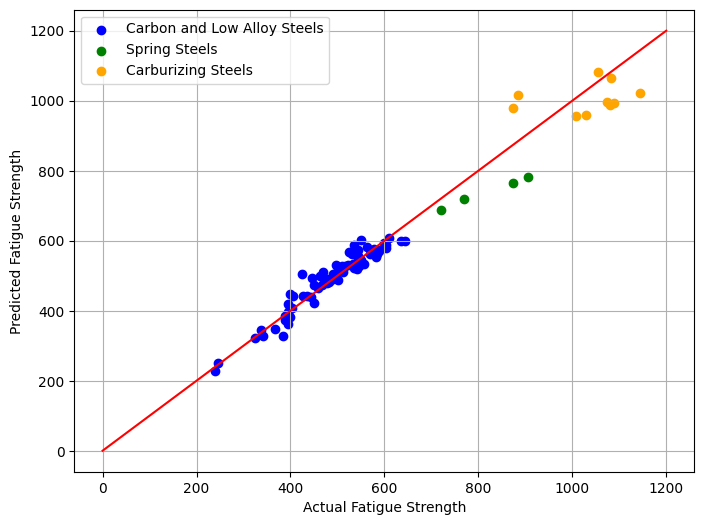

In [16]:
plt.figure(figsize=(8, 6))

for index_range, color, label in [([0, 370], 'blue', 'Carbon and Low Alloy Steels'), 
                                  ([371, 388], 'green', 'Spring Steels'), 
                                  ([389, 436], 'orange', 'Carburizing Steels')]:
    mask = y_test.index.isin(range(index_range[0], index_range[1]+1))
    plt.scatter(y_test[mask], predictions_RFE[mask], color=color, label=label)

plt.xlabel('Actual Fatigue Strength')
plt.ylabel('Predicted Fatigue Strength')
plt.legend()
plt.grid(True)
x = np.linspace(0, 1200, 1000)
plt.plot(x, x, color='red')
plt.show()

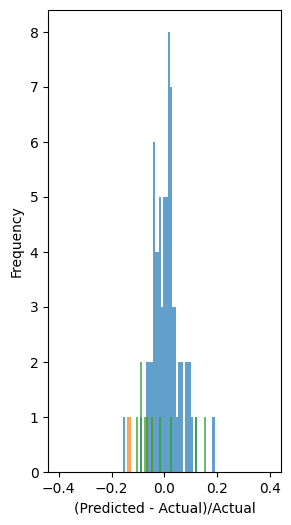

In [8]:

bins = np.linspace(-0.4, 0.4, 100)

plt.figure(figsize=(3, 6))

for label, (start_idx, end_idx) in ranges.items():
    mask = y_test.index.isin(range(start_idx, end_idx+1))
    error_fractions_subset = (predictions_RFE[mask] - y_test[mask]) / y_test[mask]
    plt.hist(error_fractions_subset, bins=bins, label=label, alpha=0.7)

plt.xlabel('(Predicted - Actual)/Actual')
plt.ylabel('Frequency')
# plt.grid(True)
# plt.legend()
plt.show()


In [9]:
pipeline.fit(X_train, y_train)
predictions_all_features = pipeline.predict(X_test)
r2_test_all_features = r2_score(y_test, predictions_all_features)
print('Test R^2 with all features:', r2_test_all_features)

Test R^2 with all features: 0.9629678825381596


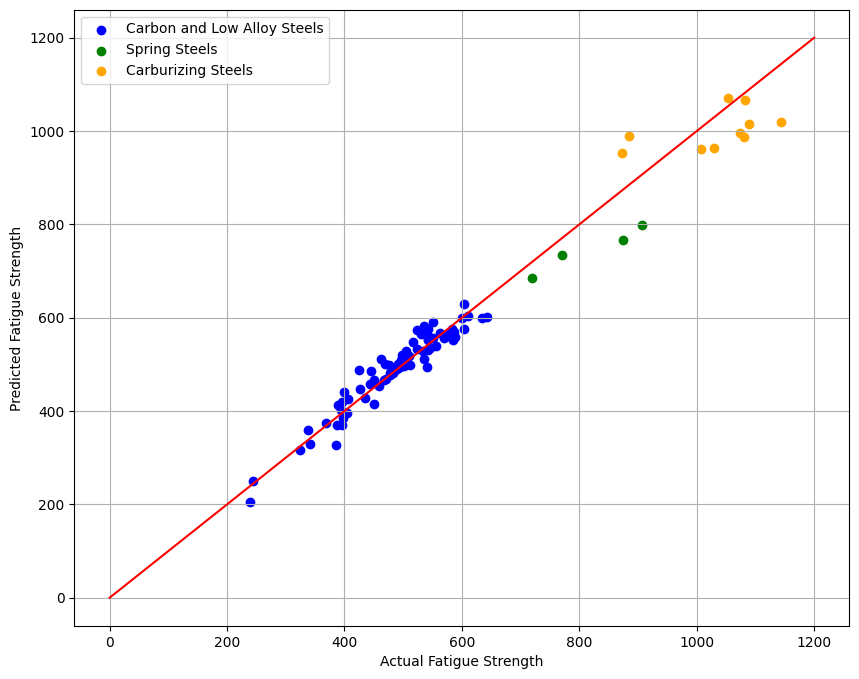

In [10]:
plt.figure(figsize=(10, 8))

for index_range, color, label in [([0, 370], 'blue', 'Carbon and Low Alloy Steels'), 
                                  ([371, 388], 'green', 'Spring Steels'), 
                                  ([389, 436], 'orange', 'Carburizing Steels')]:
    mask = y_test.index.isin(range(index_range[0], index_range[1]+1))
    plt.scatter(y_test[mask], predictions_all_features[mask], color=color, label=label)

plt.xlabel('Actual Fatigue Strength')
plt.ylabel('Predicted Fatigue Strength')
plt.legend()
plt.grid(True)
x = np.linspace(0, 1200, 1000)
plt.plot(x, x, color='red')
plt.show()

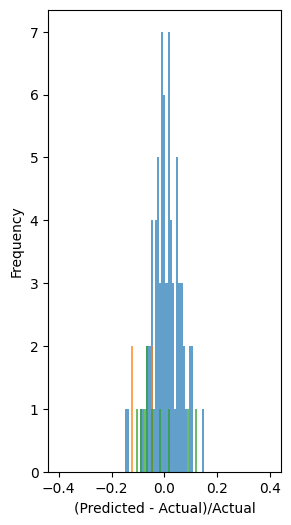

In [11]:
bins = np.linspace(-0.4, 0.4, 100)

# Initialize the figure
plt.figure(figsize=(3, 6))

for label, (start_idx, end_idx) in ranges.items():
    mask = y_test.index.isin(range(start_idx, end_idx+1))
    error_fractions_subset = (predictions_all_features[mask] - y_test[mask]) / y_test[mask]
    plt.hist(error_fractions_subset, bins=bins, label=label, alpha=0.7)

plt.xlabel('(Predicted - Actual)/Actual')
plt.ylabel('Frequency')
# plt.grid(True)
# plt.legend()
plt.show()